## [Данные Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19)

Код для загрузки файлов

In [10]:
import os, datetime, requests

TODAY = datetime.date.today()
PATH = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
MYPATH = './'
FILENAME_CASES = 'time_series_covid19_confirmed_global.csv'
FILENAME_DEATHS = 'time_series_covid19_deaths_global.csv'
FILENAME_RECOVERED = 'time_series_covid19_recovered_global.csv'
FILES = [FILENAME_CASES, FILENAME_DEATHS, FILENAME_RECOVERED]

def update_local_files():
    print('Starting update...')
    for file in FILES:
        r = requests.get(PATH+file)
        if r.status_code != requests.codes.ok:
            print(f"Failed to fetch {file}")
        with open(MYPATH+file, "wb") as f:
            f.write(r.content)
        print(f'Saved {MYPATH + file}')
    print('All done. Last update made on', str(TODAY))

Скачаем файлы

In [11]:
update_local_files()

Starting update...
Saved ./time_series_covid19_confirmed_global.csv
Saved ./time_series_covid19_deaths_global.csv
Saved ./time_series_covid19_recovered_global.csv
All done. Last update made on 2020-10-09


Код, собирающий вместе данные из разных файлов по заданной стране

In [12]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt ## пригодится для plt.saveplot()

FILENAME_CASES = 'time_series_covid19_confirmed_global.csv'
FILENAME_DEATHS = 'time_series_covid19_deaths_global.csv'
FILENAME_RECOVERED = 'time_series_covid19_recovered_global.csv'
MYPATH = './'

cases_global = pd.read_csv(MYPATH + FILENAME_CASES)
deaths_global = pd.read_csv(MYPATH + FILENAME_DEATHS)
recovered_global = pd.read_csv(MYPATH + FILENAME_RECOVERED)

def transform_data(data_list):
    '''
    Преобразуем из каждую из time series в таблицу (индексы - даты, первая колонка - значения), вернем список таблиц
    '''
    result = []
    for data in data_list:
        data.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace=True)
        data.columns = pd.to_datetime(data.columns)
        data = data.squeeze()
        result.append(data)
    return result

def process_data(country):
    '''
    Соберем в один dataframe из трех разных файлов данные по заданной стране (country)
    '''
    country_cases = cases_global[cases_global['Country/Region'] == country][:]
    country_deaths = deaths_global[deaths_global['Country/Region'] == country][:]
    country_recovered = recovered_global[recovered_global['Country/Region'] == country][:]
    country_cases, country_deaths, country_recovered = transform_data([country_cases, country_deaths, country_recovered])
    country_cases.name = f'Cases {country}'
    country_deaths.name = f'Deaths {country}'
    country_recovered.name = f'Recovered {country}'
    country_active = country_cases - country_deaths - country_recovered
    country_active.name = f'Active Cases {country}'
    result = pd.concat([country_cases, country_recovered, country_deaths, country_active], axis=1)
    return result


## Данные по России

### Общая картина

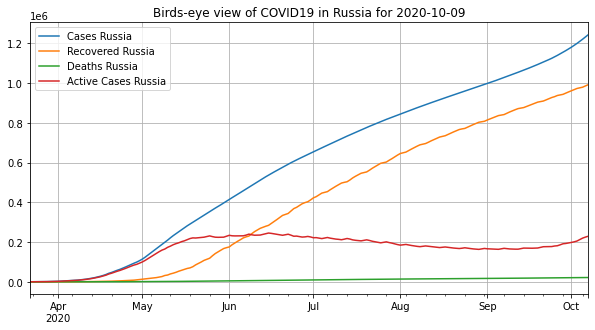

In [13]:
DAYS = 150 ## задает число дней, которые увидим на графике
 
data_rus = process_data('Russia')
DAYS = 200
data_rus[-DAYS:].plot(legend=True, grid=True, title=f"Birds-eye view of COVID19 in Russia for {TODAY}", figsize=(10,5))
#plt.savefig(f"{TODAY}_Overall_RU.jpeg") # сохраняем картинку

In [14]:
data_rus.tail(5)

,Cases Russia,Recovered Russia,Deaths Russia,Active Cases Russia
2020-10-03,1198663,972249,21153,205261
2020-10-04,1209039,975488,21260,212291
2020-10-05,1219796,978610,21375,219811
2020-10-06,1231277,984767,21559,224951
2020-10-07,1242258,991277,21755,229226


### Активные случаи (зарегистрированные случаи минус выздоровевшие минус умершие)



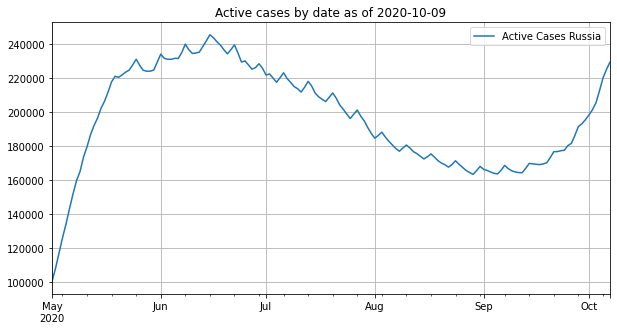

In [15]:
DAYS = 160 ## задает число дней, которые увидим на графике
data_rus["Active Cases Russia"][-DAYS:].plot(legend=True, grid=True, title=f"Active cases by date as of {TODAY}", figsize=(10,5))
#plt.savefig(f"{TODAY}_Active_Cases_RU.jpeg") # сохраняем картинку

In [16]:
data_rus["Active Cases Russia"].tail(5)

2020-10-03    205261
2020-10-04    212291
2020-10-05    219811
2020-10-06    224951
2020-10-07    229226
Name: Active Cases Russia, dtype: int64

### Прирост активных случаев (активных случаев сегодня - активных случаев вчера)

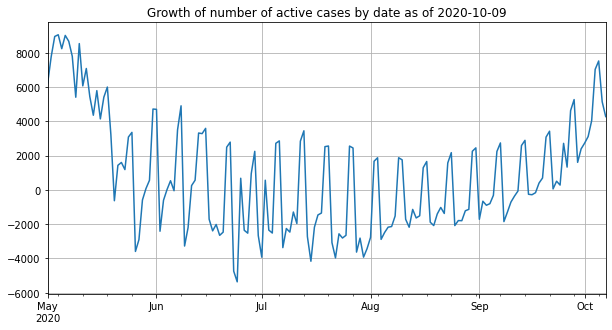

In [17]:
DAYS = 160 # Число дней, за которые увидим динамику
active_cases_shift_one_day = pd.Series(data_rus["Active Cases Russia"][:-1])
active_cases_shift_one_day.index = data_rus["Active Cases Russia"].index[1:]
'''
for i in range(1,31):
    print(active_cases_ru.index[-i], active_cases_ru[-i], round(active_cases_ru[-i] / active_cases_ru[-i - 1], 2))
'''
abs_growth_active_cases_ru = data_rus["Active Cases Russia"] - active_cases_shift_one_day
abs_growth_active_cases_ru[-DAYS:].plot(grid=True, title=f"Growth of number of active cases by date as of {TODAY}", figsize=(10,5))
#plt.savefig(f"{TODAY}_Active_Cases_Growth_By_Day_RU.jpeg") # сохраняем картинку

In [18]:
abs_growth_active_cases_ru.tail(5)

2020-10-03    4038.0
2020-10-04    7030.0
2020-10-05    7520.0
2020-10-06    5140.0
2020-10-07    4275.0
Name: Active Cases Russia, dtype: float64

### Прирост числа зарегистрированных случаев (зарегистрированных случаев сегодня минус зарегистрированных случаев вчера)



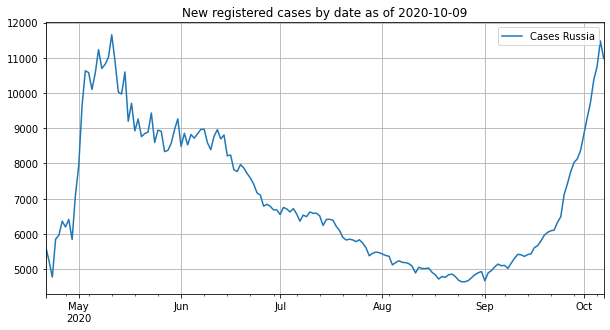

In [19]:
DAYS = 170
newcases_less_one_day = data_rus["Cases Russia"][:-1]
newcases_less_one_day.index = data_rus["Cases Russia"].index[1:]
abs_registered_cases_growth = data_rus["Cases Russia"] - newcases_less_one_day

abs_registered_cases_growth[-DAYS:].plot(legend=True, grid=True, title=f"New registered cases by date as of {TODAY}", figsize=(10,5))
#plt.savefig(f"New_Registered_Cases_RU-{TODAY}.jpeg") # сохраняем картинку

In [20]:
abs_registered_cases_growth.tail(5)

2020-10-03     9735.0
2020-10-04    10376.0
2020-10-05    10757.0
2020-10-06    11481.0
2020-10-07    10981.0
Name: Cases Russia, dtype: float64

## Графики по некоторым странам

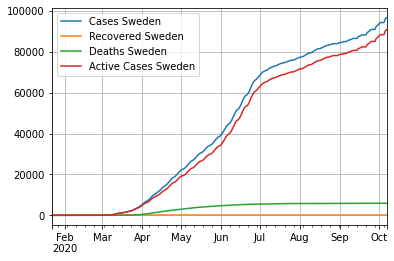

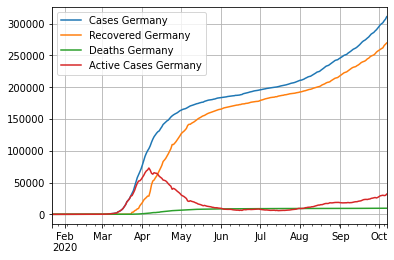

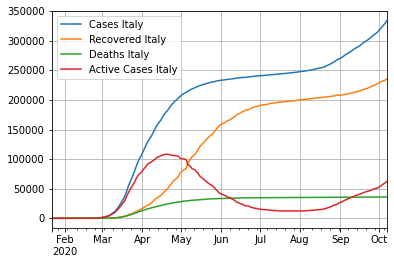

In [21]:
data_swe = process_data('Sweden')
data_de = process_data('Germany')
data_it = process_data('Italy')

data_swe.plot(legend=True, grid=True)
data_de.plot(legend=True, grid=True)
data_it.plot(legend=True, grid=True)

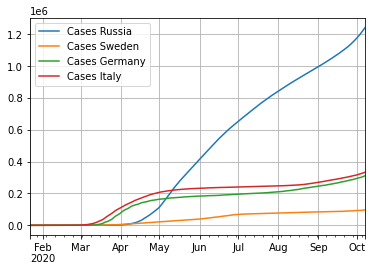

In [22]:
data_rus['Cases Russia'].plot(legend=True, grid=True)
data_swe['Cases Sweden'].plot(legend=True, grid=True)
data_de['Cases Germany'].plot(legend=True, grid=True)
data_it['Cases Italy'].plot(legend=True, grid=True)
# plt.savefig("ru_de_it.png")

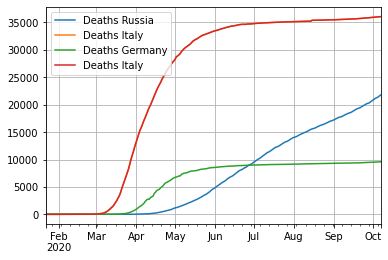

In [23]:
data_rus['Deaths Russia'].plot(legend=True, grid=True)
data_it['Deaths Italy'].plot(legend=True, grid=True)
data_de['Deaths Germany'].plot(legend=True, grid=True)
data_it['Deaths Italy'].plot(legend=True, grid=True)